1) Exploración, análisis, selección de variables y creación del
modelo sobre conjunto de train (12 puntos)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
# Cargamos el dataframe de las transacciones
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
df_tx = pd.read_csv(
    's3://moneylaudering/train.csv',
    dtype=dtype,
    index_col='id',
    parse_dates=['date'],
    date_parser=parser,
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_tx = df_tx.set_index('date')
average_tx = df_tx.groupby('date').mean()['sales']

In [5]:
df_avr_tx = average_tx.to_frame()

In [6]:
df_avr_tx.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1684, freq=None)

In [7]:
df_avr_tx = df_avr_tx.asfreq('MS')

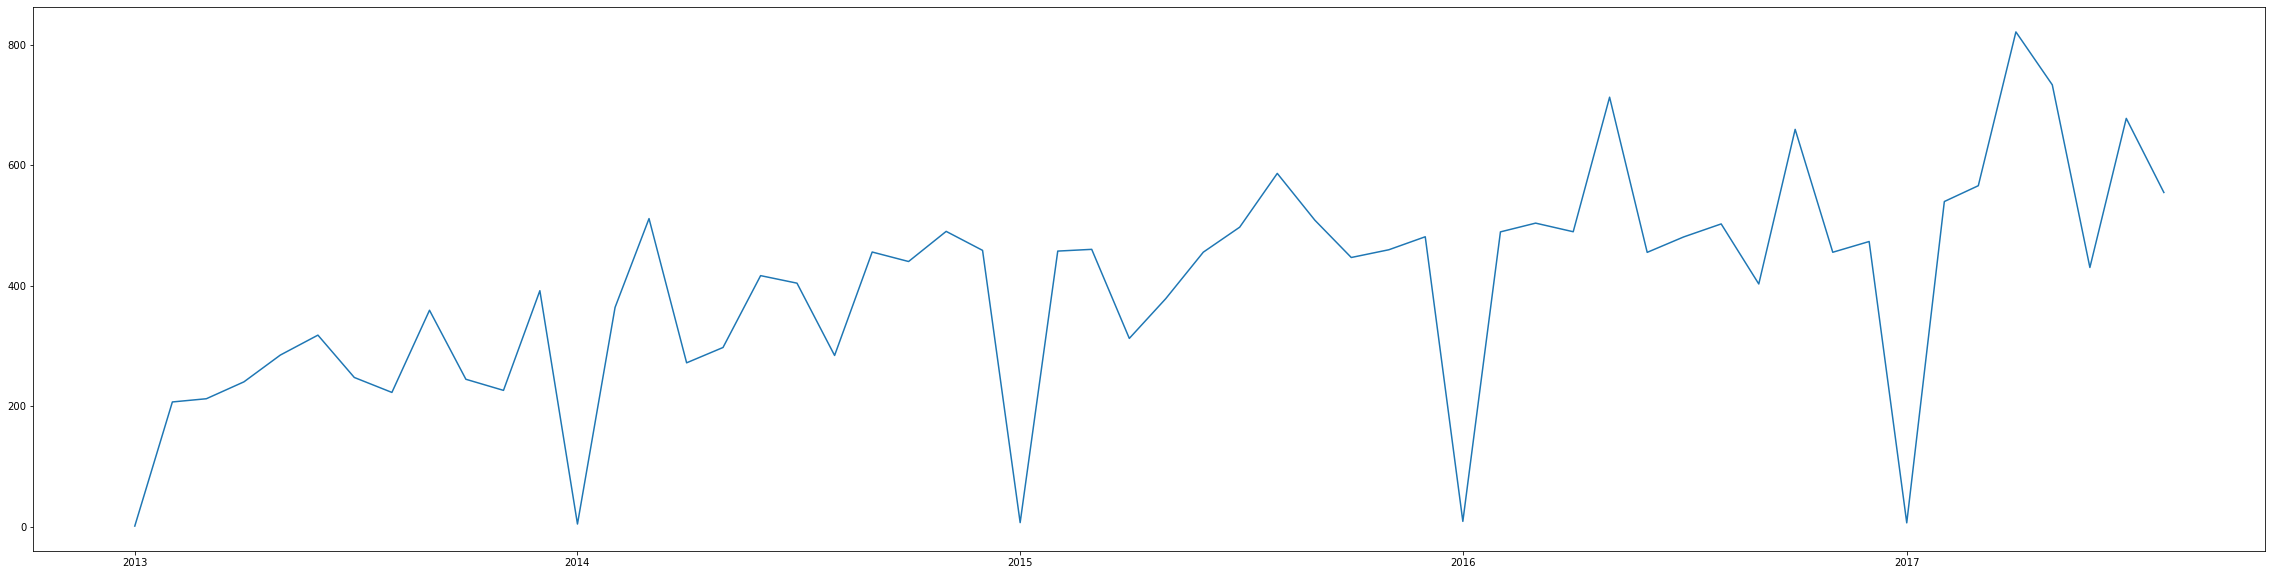

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,10))
plt.plot(df_avr_tx)


In [9]:
df_avr_tx.shape

(56, 1)

In [10]:
df_avr_tx.tail()

,sales
date,
2017-04-01,821.034790
2017-05-01,733.276855
2017-06-01,430.336243
2017-07-01,677.626221
2017-08-01,554.729370


Se escalan el dataframe serie de tiempo para hacer el entrenamiento con los datos escalados.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_avr_tx.values.reshape(-1, 1))
df_scaled = pd.DataFrame(np_scaled)
df_scaled.head()

,0
0,-2.208992
1,-1.066752
2,-1.037188
3,-0.881778
4,-0.635335


Se crea una copia del dataframe para entrenar el modelo Isolation Forest para identificar las anomalías.

In [12]:
df_isoforest = df_avr_tx.copy()
outliers_fraction = float(0.06) 

In [13]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(df_scaled)

IsolationForest(contamination=0.06)

In [14]:
df_isoforest['anomaly'] = model.predict(df_scaled)
a = df_isoforest.loc[df_isoforest['anomaly'] == -1, ['sales']] 


In [15]:
a.head()

,sales
date,
2013-01-01,1.409438
2014-01-01,4.827197
2016-01-01,9.221882
2017-04-01,821.034790


In [16]:
df_predict = pd.DataFrame()

date = ['2017-09-01', '2017-10-01'] 
sales = [800,150] 
df_predict['date'] = date 
df_predict['sales'] = sales 
df_predict = df_predict.set_index('date')

print(df_predict)

            sales
date             
2017-09-01    800
2017-10-01    150


In [17]:
np_pred_scaled = scaler.transform(df_predict.values.reshape(-1, 1))
df_pred_scaled = pd.DataFrame(np_pred_scaled)
df_pred_scaled.head()



,0
0,2.221508
1,-1.384627


In [18]:
df_pred_scaled_result = df_pred_scaled.copy()
df_pred_scaled_result['anomaly'] = model.predict(df_pred_scaled)

In [19]:
df_pred_scaled_result.head()

,0,anomaly
0,2.221508,-1
1,-1.384627,1


In [20]:
df_predict

,sales
date,
2017-09-01,800
2017-10-01,150


In [21]:
df_pred_scaled

,0
0,2.221508
1,-1.384627


2) Creación de
pipeline (10 puntos)


**Pipeline Scalado**

In [22]:
from sklearn.pipeline import Pipeline
data_pipe = Pipeline(
    [
        ('Escalado Estandar', StandardScaler()),
        #('Entrenar Modelo de Aislamiento', IsolationForest(contamination=0.06)),
        #('Retornar outliers', outliers(model,df_predict,df_pred_scaled)),
    ]
)

In [23]:
df_avr_tx_pipe = df_avr_tx.copy()
df_scaladed_pipe = pd.DataFrame(data_pipe.fit_transform(df_avr_tx_pipe.values.reshape(-1, 1)))

In [24]:
df_scaladed_pipe.head()

,0
0,-2.208992
1,-1.066752
2,-1.037188
3,-0.881778
4,-0.635335


**Pipeline Modelo**

In [25]:
model_pipeline = Pipeline(
    [
        ("Escalado Estandar",StandardScaler()),
        ("Modelo Arboles de Aislamiento",IsolationForest(contamination=0.06))
    ]
)

In [26]:
model_pipeline.fit(df_isoforest.values.reshape(-1, 1))

Pipeline(steps=[('Escalado Estandar', StandardScaler()),
                ('Modelo Arboles de Aislamiento',
                 IsolationForest(contamination=0.06))])

In [27]:
df_isoforest

,sales,anomaly
date,,
2013-01-01,1.409438,-1
2013-02-01,207.296326,1
2013-03-01,212.625229,1
2013-04-01,240.637741,1
2013-05-01,285.058716,1
2013-06-01,318.126709,1
2013-07-01,247.900330,1
2013-08-01,223.095016,1
2013-09-01,359.374969,1


In [28]:
model_pipeline.predict(df_pred_scaled)

array([1, 1])

5) Creación de Joblib (10 Puntos)

In [29]:
import joblib
joblib.dump(model_pipeline, "money_anomalies.joblib")

['money_anomalies.joblib']

In [30]:
model_joblib=joblib.load('money_anomalies.joblib')

In [31]:
df_pred_scaled

,0
0,2.221508
1,-1.384627


In [32]:
model_joblib.predict(df_pred_scaled)

array([1, 1])

6) Despliegue del
modelo usando Sagemaker SDK.

In [33]:
import sagemaker 
from sagemaker.sklearn import SKLearnModel
from sagemaker.serializers import CSVSerializer

In [34]:
!tar -zcvf money_anomalies.tar.gz money_anomalies.joblib

money_anomalies.joblib


In [35]:
session = sagemaker.Session()

In [36]:
s3_uri_model = session.upload_data(bucket="moneylaudering", key_prefix="model", path="money_anomalies.tar.gz")

In [37]:

%%writefile entry_point.py
import joblib
import os
def model_fn(model_path):
    return joblib.load(os.path.join(model_path, 'money_anomalies.joblib'))


Overwriting entry_point.py


6) Creación de Endpoint (8 puntos)

In [38]:
model = SKLearnModel(entry_point='entry_point.py', role='LabRole', framework_version='1.0-1', model_data=s3_uri_model)

In [45]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!

In [52]:
predictor.serializer = CSVSerializer()

In [43]:
df_pred_scaled

,0
0,2.221508
1,-1.384627


In [46]:
predictor.predict(df_pred_scaled)

array([1, 1])

7) Creación de un servicio web que reciba los datos del usuario por POST desde un
formulario, solicite al endpoint de sagemaker la predicción del
modelo y devuelva la respuesta al usuario final como un HTML.(Usar
un EC2 con ip pública) (10 puntos)

In [53]:
payload = '[[0, 2.221508],[1,-1.384627]]'

import boto3

endpoint = 'sagemaker-scikit-learn-2022-12-09-03-22-52-607'

client = boto3.client('sagemaker-runtime','us-east-1')

response = client.invoke_endpoint(
    EndpointName=endpoint,
    Body=payload,
    ContentType='text/csv'
)

prediction = response['Body'].read()
print(prediction)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-scikit-learn-2022-12-09-03-22-52-607 in account 749244069637 for more information.

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-scikit-learn-2022-12-09-03-22-52-607 in account 749244069637 for more information.